In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import inv
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 50]


In [3]:
train = pd.read_csv("ts_train.csv")
test = pd.read_csv("ts_test.csv")

In [4]:
class ARI:
    def __init__(self, window, s=[10], d=1):
        self.d = d
        self.s = s
        self.window  = window
        self.weights = np.array([])
        self.diff_matrix = []
        self.point = np.array([])
    
    
    def difference(self, data):
        old_diff_data = None
        diff_data = data
        self.diff_matrix.append(data)
        
        for k in range(len(self.s)):
            old_diff_data = diff_data
            diff_data = []
            assert self.s[k] < len(old_diff_data)
            for i in range(self.s[k], len(old_diff_data)):
                diff_data.append(old_diff_data[i] - old_diff_data[i-self.s[k]])
            self.diff_matrix.append(diff_data)
        for d in range(self.d):
            old_diff_data = diff_data
            diff_data = []
            for j in range(1, len(old_diff_data)):
                diff_data.append(old_diff_data[j] - old_diff_data[j-1])
            self.diff_matrix.append(diff_data)
            
        return diff_data
    
    
    def regresion(self, features, targets):
        weights = ((inv((features.T).dot(features))).dot(
            features.T)).dot(targets)
        return weights
    
    
    def train(self, raw_data):
        data = self.difference(raw_data)
        
        t = len(data) - 1
        feature_matrix = []
        targets = []
        for i in range(self.window, t+1):
            datum = np.array([data[k] for k in range(i-self.window, i)])
            feature_matrix.append(datum)
            targets.append(data[i])
        targets = np.array(targets)
        targets = targets.reshape((-1, 1))
        
        self.weights = self.regresion(np.array(feature_matrix), targets)
        self.point = data[(len(data)-self.window):]
        
    def predict_point(self):
      
        self.diff_matrix = np.array(self.diff_matrix)
        pred = ((self.weights).flatten()).dot(self.point)
        
        for k in range(len(self.s), len(self.diff_matrix)-1):
            pred = pred + self.diff_matrix[len(self.s)-2-k][-1]
            
        for m in range(len(self.s)):
            pred = self.diff_matrix[len(self.s)-m-1][-self.s[m]]+pred
            
        return pred

In [5]:
prediction = []
for index in range(1, 23):
    train_set = []
    p = []
    for _ in range(len(test[test.tsID==index])):
        train_set = [*list(train[train.tsID==index]["ACTUAL"]), *p]
        m_ari = ARI(window=20, s=[365], d=0)
        m_ari.train(train_set)
        p.append(m_ari.predict_point())
        del(m_ari)
    prediction.append(p)
    del(p)
    del(train_set)
        
    
    

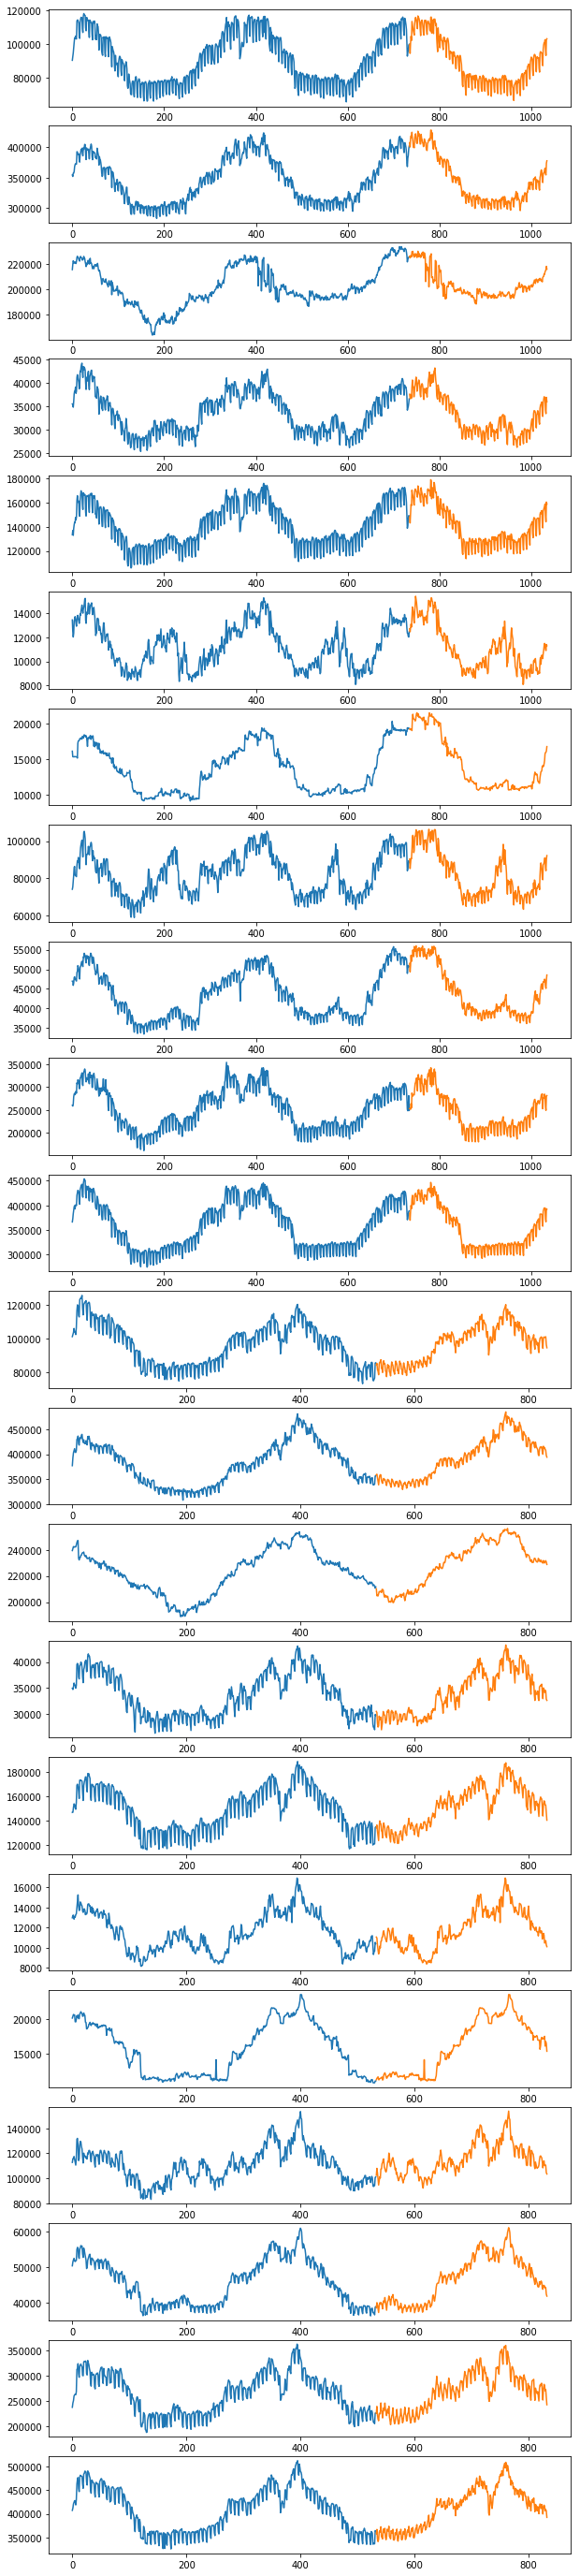

In [7]:
for index in range(1, 23):
    plt.subplot(22, 1, index)
    plt.plot(np.arange(len(train[train.tsID==index])), train[train.tsID==index]['ACTUAL'])
    plt.plot(np.arange(len(train[train.tsID==index]), 
        len(train[train.tsID==index])+len(test[test.tsID==index])), prediction[index-1])